In [1]:
# IMPORT PACKAGES
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import os
from sklearn import linear_model as lm, metrics, ensemble as ens
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
import warnings
from sklearn.utils import resample

2024-10-03 13:40:11.194690: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# PULL IN SAVED CSV FROM HP-TUNING NOTEBOOK TO SAVE TIME
df = pd.read_csv("full_info.csv")
df['state'] = df['state'].apply(lambda x: re.sub('District Of Columbia', 'District of Columbia', x))
df = df[df['total_population'] >= 50000]

df_latest = pd.read_csv("latest_years.csv")
df_latest = df_latest.drop(columns = ['rent_in_three', 'three_year_growth'])
df_latest = df_latest[df_latest['total_population'] >= 50000]

In [3]:
df = pd.get_dummies(df, prefix = 'state', columns = ['state'])
df_latest = pd.get_dummies(df_latest, prefix = 'state', columns = ['state'])

In [4]:
for col in df.columns:
    if 'state' in col:
        df[col] = df[col].apply(lambda x: 1 if x == True else 0)

In [5]:
df_latest = df_latest[df_latest['year'] == df_latest['year'].max()]

In [6]:
# GETTING AN IDEA OF HOME VALUES AS THIS AFFECTS BUDGET DIRECTLY
print('mean current value: ', df_latest['average_home_value'].mean())
print('median current value: ', df_latest['average_home_value'].median())
print('25th percentile current value: ', np.percentile(df_latest['average_home_value'], 25))
print('number 200k or less: ', len(df_latest[df_latest['average_home_value'] <= 200000]))

mean current value:  441034.37650975893
median current value:  371733.4
25th percentile current value:  254659.86
number 200k or less:  108


THE BELOW IS A PLAIN PULL OF CANDIDATES AS DEFINED BY SOME OF MY OWN CRITERIA (I.E. NOT ON AN ISLAND OR IN TOO LARGE OF A STATE, WITHIN BUDGET, A FAIRLY LARGE POPULATION AND VACANCY RATE DECLINING OF THE LAST THREE YEARS).

In [7]:
df_latest_candidates = df_latest.sort_values(by = 'average_home_value').drop(columns = [x for x in df_latest.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and \
                                        'roi' not in x and 'vacancy' not in x])

df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('California')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('New York')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Puerto Rico')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Hawaii')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Texas')]
df_latest_candidates = df_latest_candidates[~df_latest_candidates['place'].str.contains('Florida')]
df_latest_candidates = df_latest_candidates[df_latest_candidates['average_home_value'] <= 250000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['total_population'] >= 100000]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_1_years'] < 0]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_3_years'] < df_latest_candidates['vacancy_growth_last_2_years']]
df_latest_candidates = df_latest_candidates[df_latest_candidates['vacancy_growth_last_2_years'] < df_latest_candidates['vacancy_growth_last_1_years']] 
df_latest_candidates.sort_values(by = 'vacancy_rate')

,year,place,average_annual_rent,average_home_value,total_population,vacancy_rate,vacancy_growth_last_1_years,vacancy_growth_last_2_years,vacancy_growth_last_3_years
112903,2022,Green Bay city - Wisconsin,9236.04,207376.55,106846,0.038405,-0.144985,-0.226759,-0.232500
104170,2022,Broken Arrow city - Oklahoma,12686.64,241907.74,114237,0.050297,-0.087292,-0.114080,-0.115551
97802,2022,Springfield city - Missouri,9197.04,180109.81,168873,0.050461,-0.082215,-0.175844,-0.342374
89354,2022,Joliet city - Illinois,12369.72,246262.48,150221,0.057373,-0.006929,-0.104471,-0.178888
95522,2022,Warren city - Michigan,11364.36,171685.02,138588,0.063109,-0.060786,-0.183544,-0.209669
86312,2022,Pueblo city - Colorado,10124.40,234415.38,111430,0.063935,-0.082590,-0.220793,-0.318264
94989,2022,Dearborn city - Michigan,13392.72,233492.03,108414,0.071170,-0.066968,-0.164560,-0.258202
100104,2022,Las Cruces city - New Mexico,9871.32,223360.87,111273,0.071916,-0.167887,-0.253698,-0.330282
108191,2022,Clarksville city - Tennessee,11916.48,239749.65,167882,0.073616,-0.098334,-0.236165,-0.293594
90433,2022,Fort Wayne city - Indiana,9245.64,176476.01,264514,0.074725,-0.070493,-0.137034,-0.179821


Text(0, 0.5, 'Number of Counties')

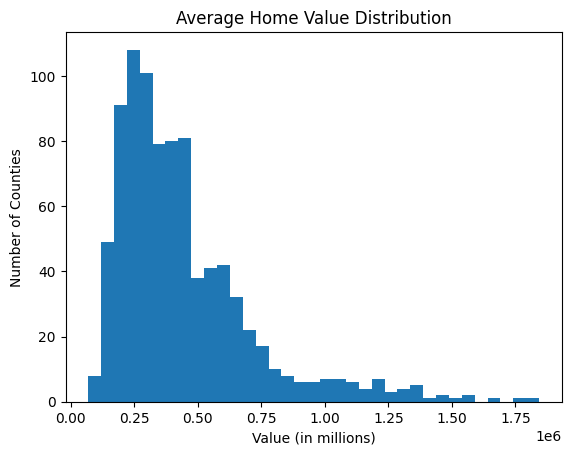

In [8]:
# VISUALIZE DISTRIBUTION OF HOME VALUE
plt.hist(df_latest['average_home_value'], bins = 35)
plt.title("Average Home Value Distribution")
plt.xlabel("Value (in millions)")
plt.ylabel("Number of Counties")


In [9]:
# AND GET A BASELINE IDEA OF VACANCY FOR COMPARISON WITH CANDIDATES
df_latest['vacancy_rate'].mean()

0.07663215712259834

Text(0, 0.5, 'Number of Counties')

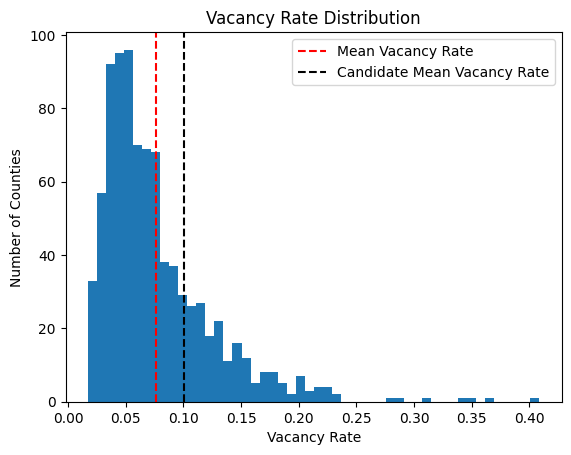

In [10]:
# VACANCY DISTRIBUTION
plt.hist(df_latest['vacancy_rate'], bins = 50)
plt.axvline(df_latest['vacancy_rate'].mean(), color = 'r', linestyle = 'dashed', label = 'Mean Vacancy Rate')
plt.axvline(df_latest_candidates['vacancy_rate'].mean(), color = 'k', linestyle = 'dashed', label = 'Candidate Mean Vacancy Rate')
plt.legend()
plt.title("Vacancy Rate Distribution")
plt.xlabel("Vacancy Rate")
plt.ylabel("Number of Counties")


NOTE THAT CANDIDATES HAVE A HIGHER VACANCY RATE ON AVERAGE; THIS MAYBE SHOULDN'T BE SHOCKING SINCE THEY ARE DECLINING FOR THREE YEARS STEADY - ONES THAT WERE ALREADY LOW HAD LESS ROOM FOR A DECREASE

In [11]:
print('mean current vacancy rate: ', df_latest['vacancy_rate'].mean())
print('median current vacancy rate: ', df_latest['vacancy_rate'].median())
print('25th percentile current vacancy rate: ', np.percentile(df_latest['vacancy_rate'], 25))


mean current vacancy rate:  0.07663215712259834
median current vacancy rate:  0.0636527002742835
25th percentile current vacancy rate:  0.043996775807165406


(array([ 8., 21., 27., 23., 40., 45., 35., 52., 47., 42., 42., 38., 23.,
        38., 29., 29., 30., 21., 18., 18., 20., 14., 16., 11., 11., 12.,
         9., 17., 10.,  7., 13.,  7.,  5.,  7.,  5.,  7.,  9.,  8.,  2.,
         1.,  2.,  5.,  4.,  2.,  6.,  2.,  3.,  1.,  2.,  3.]),
 array([0.01745517, 0.02106083, 0.0246665 , 0.02827217, 0.03187783,
        0.0354835 , 0.03908917, 0.04269483, 0.0463005 , 0.04990616,
        0.05351183, 0.0571175 , 0.06072316, 0.06432883, 0.0679345 ,
        0.07154016, 0.07514583, 0.0787515 , 0.08235716, 0.08596283,
        0.0895685 , 0.09317416, 0.09677983, 0.10038549, 0.10399116,
        0.10759683, 0.11120249, 0.11480816, 0.11841383, 0.12201949,
        0.12562516, 0.12923083, 0.13283649, 0.13644216, 0.14004782,
        0.14365349, 0.14725916, 0.15086482, 0.15447049, 0.15807616,
        0.16168182, 0.16528749, 0.16889316, 0.17249882, 0.17610449,
        0.17971016, 0.18331582, 0.18692149, 0.19052715, 0.19413282,
        0.19773849]),
 <BarContainer

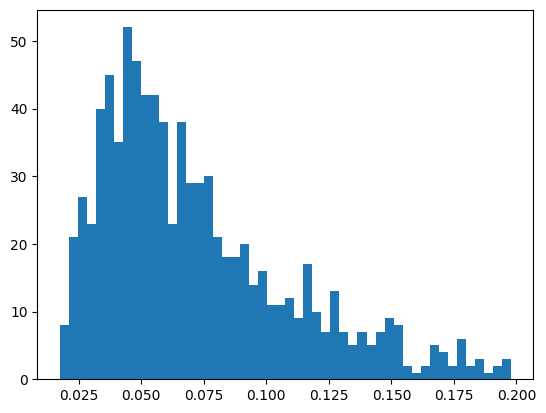

In [12]:
# A CLOSER LOOK AT DISTRIBUTION WITHOUT SOME OF THE OUTLIERS
plt.hist(df_latest[df_latest['vacancy_rate'] < 0.2]['vacancy_rate'], bins = 50)

In [13]:
df_orig = df.copy()

In [14]:
# MAKE VALI DATA SECOND TO LAST YEAR; TEST DATA LAST YEAR; TRAIN FIRST 6
last_year = df['year'].max()
train = df[df['year'] < last_year - 4]
vali = df[df['year'] == last_year - 1]
test = df[df['year'] == last_year]

In [15]:
print('training sample - ', len(train))
print('validation sample - ', len(vali))
print('test sample - ', len(test))

training sample -  4663
validation sample -  836
test sample -  840


In [16]:
for yr in set(df['year'].values.tolist()):
    print(yr, len(df[df['year'] == yr]))

2016 820
2017 826
2018 836
2019 840
2009 750
2010 765
2011 770
2012 785
2013 791
2014 802
2015 815


In [17]:
# SIZE OF DATASET WITH KNOWN ROI, WITH UNKNOWN ROI
print(len(df))
print(len(df_latest))

8800
871


In [18]:
# TESTING SHOWS MODELS STRUGGLE WITH IDENTIFYING TOP PERFORMERS WELL - TRYING UPSAMPLING
# high_roi_threshold = train['roi'].quantile(0.75)
high_cash_threshold = 300000
low_cash_threshold = 185000
year_threshold = 2013

# Separate majority and minority classes
# high_roi = train[train.roi > high_roi_threshold]
# high_roi = train[train.average_home_value.between(low_cash_threshold, high_cash_threshold)]
high_roi = train[train.year >= year_threshold]
high_roi = high_roi[high_roi.state_California == 0]
high_roi = high_roi[high_roi.state_Texas == 0]

# low_roi = train[train.roi <= high_roi_threshold]
# low_roi = train[(train.average_home_value > high_cash_threshold) | (train.average_home_value < low_cash_threshold)]
# low_roi = train[train.year < year_threshold]
low_roi = train[~train.index.isin(list(high_roi.index))]

# Upsample minority class
high_roi_upsampled = resample(high_roi, 
                              replace=True,     # sample with replacement
                              n_samples=len(low_roi),    # to match majority class
                              random_state=42) # reproducible results

# Combine majority class with upsampled minority class
upsampled = pd.concat([low_roi, high_roi_upsampled])


In [19]:
# TESTING HAS SHOWN FAKE PREDS BEATS MODEL - WANNA SEE WHAT HAPPENS IF FAKE PRED IS A FEATURE
train['fake_pred'] = round(((train['average_home_value'] * (1 + train['home_val_growth_last_3_years']) - train['average_home_value']) + \
                     (
                        train['average_annual_rent'] * (1 + train['rent_growth_last_1_years']) +\
                        train['average_annual_rent'] * (1 + train['rent_growth_last_2_years']) +\
                        train['average_annual_rent'] * (1 + train['rent_growth_last_3_years'])
                     ))/train['average_home_value'], 4)

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15587/2596095845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['fake_pred'] = round(((train['average_home_value'] * (1 + train['home_val_growth_last_3_years']) - train['average_home_value']) + \


In [20]:
vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \
                     (
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_1_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_2_years']) +\
                        vali['average_annual_rent'] * (1 + vali['rent_growth_last_3_years'])
                     ))/vali['average_home_value'], 4)

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15587/1132831924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali['fake_pred'] = round(((vali['average_home_value'] * (1 + vali['home_val_growth_last_3_years']) - vali['average_home_value']) + \


In [21]:
#X, Y SPLITS
std_scl = StandardScaler()

ex_train = train.drop(columns = ['year', 'place', 'roi'])
ex_train_scaled = std_scl.fit_transform(ex_train)
why_train = train['roi']

ex_train_upsampled = upsampled.drop(columns = ['year', 'place', 'roi'])
ex_train_upsampled_scaled = std_scl.fit_transform(ex_train_upsampled)
why_train_upsampled = upsampled['roi']


ex_vali = vali.drop(columns = ['year', 'place', 'roi'])
ex_vali_scaled = std_scl.fit_transform(ex_vali)
why_vali = vali['roi']

ex_test = test.drop(columns = ['year', 'place', 'roi'])
ex_test_scaled = std_scl.fit_transform(ex_test)
why_test = test['roi']

In [22]:
mse = metrics.mean_squared_error
mae = metrics.mean_absolute_error

In [23]:
print('actuals mean - ', why_vali.mean())
print('actuals standard dev - ', why_vali.std())

actuals mean -  0.3233958133971292
actuals standard dev -  0.09878526930445224


In [24]:
# ALSO NOTING TEST SET STANDARD DEVIATION
why_test.std()

0.11087949852904222

In [25]:
print('rmse - ', m.sqrt(mse(why_vali, vali['fake_pred'])))
print('mae - ', mae(why_vali, vali['fake_pred']))
vali = vali.drop(columns = ['fake_pred'])
train = train.drop(columns = ['fake_pred'])

rmse -  0.08366455757236696
mae -  0.06512547846889953


QUICK NOTE THAT I USED TO INCLUDE LOGISTIC REGRESSION; RESULTS WERE POOR TO THE POINT OF NOT BEING WORTH FURTHER EXPLORATION

In [26]:
ex_train = ex_train.drop(columns = ['fake_pred'])
ex_vali = ex_vali.drop(columns = ['fake_pred'])

In [27]:
# LOOK AT OUT OF BOX RANDOM FOREST PERFORMANCE
rf = ens.RandomForestRegressor(random_state=123)

# TRAIN/VALI
rf_fit = rf.fit(ex_train, why_train)
rf_preds = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds)))
print('mae - ', mae(why_vali, rf_preds))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds = rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds)))
print('training mae - ', mae(why_train, rf_train_preds))

rmse -  0.2077747074797552
mae -  0.17853173564593303
training rmse -  0.024066108079958307
training mae -  0.017291611408964187


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15587/433181556.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)


Text(0, 0.5, 'Feature Names')

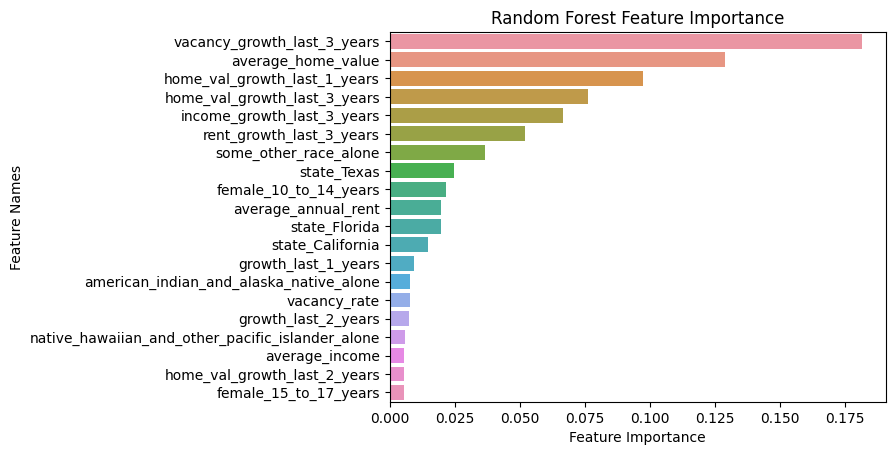

In [28]:
# PLOT MOST IMPORTANT FEATURES
feature_names = ex_train.columns
importances = rf_fit.feature_importances_
data = {'feature_names': feature_names, 'feature_importance': importances}
rf_df = pd.DataFrame(data)
rf_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
rf_df = rf_df.head(20)

sns.barplot(x = rf_df['feature_importance'], y = rf_df['feature_names'], ci = None)

#ADD CHART LABELS
plt.title('Random Forest Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')


In [29]:
# CHECK TUNED RF PERFORMANCE

In [30]:
%store -r rf_params

In [31]:
rf_params

{'rf__n_estimators': 150,
 'rf__max_depth': 25,
 'rf__criterion': 'friedman_mse',
 'pca__n_components': 19}

In [32]:
# SET THIS (AND OTHER MODELS) UP TO BE ABLE TO HANDLE PCA OR NO
if sum([1 if 'pca__' in x else 0 for x in rf_params]) > 0:
    steps = [('pca', PCA(n_components = rf_params['pca__n_components'])), 
             ('rf', ens.RandomForestRegressor(n_estimators = rf_params['rf__n_estimators'], 
                                          max_depth = rf_params['rf__max_depth'],
                                          criterion = rf_params['rf__criterion']))]
    model_rf = Pipeline(steps = steps)

    
    
else:
    
    model_rf = ens.RandomForestRegressor(n_estimators = rf_params['n_estimators'], 
                                          max_depth = rf_params['max_depth'],
                                          criterion = rf_params['criterion'])
    
# TRAIN/VALI
rf_fit = model_rf.fit(ex_train, why_train)
rf_preds_tuned = rf_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, rf_preds_tuned)))
print('mae - ', mae(why_vali, rf_preds_tuned))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
rf_train_preds_tuned = model_rf.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, rf_train_preds_tuned)))
print('training mae - ', mae(why_train, rf_train_preds_tuned))

rmse -  0.17579662775932747
mae -  0.14354749032838665
training rmse -  0.03650805412995002
training mae -  0.026311795903669034


In [33]:
# TUNED ADABOOST

In [34]:
%store -r ada_params

In [35]:
ada_params

{'n_estimators': 300, 'learning_rate': 1}

In [36]:
if sum([1 if 'pca__' in x else 0 for x in ada_params]) > 0:
    steps = [('pca', PCA(n_components = ada_params['pca__n_components'])), 
             ('ada', ens.AdaBoostRegressor(n_estimators = ada_params['ada__n_estimators'], 
                                           learning_rate = ada_params['ada__learning_rate']))]
             
    ada = Pipeline(steps = steps)
    
else:
    ada = ens.AdaBoostRegressor(n_estimators = ada_params['n_estimators'], 
                                learning_rate = ada_params['learning_rate'])

    
    
# TRAIN/VALI
ada_fit = ada.fit(ex_train, why_train)
ada_preds = ada_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, ada_preds)))
print('mae - ', mae(why_vali, ada_preds))
               
# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
ada_train_preds = ada.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, ada_train_preds)))
print('training mae - ', mae(why_train, ada_train_preds))

rmse -  0.158858681744571
mae -  0.13051809356969565
training rmse -  0.08647804087313558
training mae -  0.07125078526144778


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15587/3173871377.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)


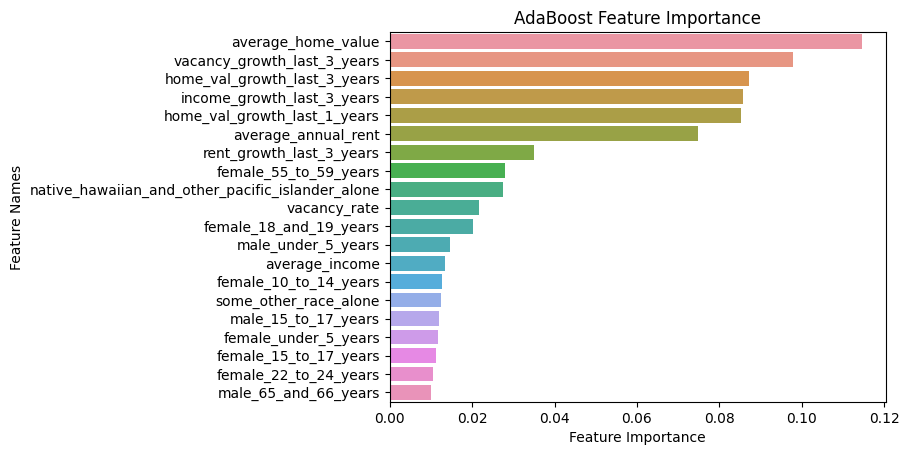

In [37]:
if sum([1 if 'pca__' in x else 0 for x in ada_params]) == 0:
    feature_names = ex_train.columns
    importances = ada_fit.feature_importances_
    data = {'feature_names': feature_names, 'feature_importance': importances}
    ada_df = pd.DataFrame(data)
    ada_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    ada_df = ada_df.head(20)

    sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)

    #ADD CHART LABELS
    plt.title('AdaBoost Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    

TRYING ADABOOST WITH EARLY STOPPING

In [38]:
if sum([1 if 'pca__' in x else 0 for x in ada_params]) > 0:
    steps = [('pca', PCA(n_components = ada_params['pca__n_components'])), 
             ('ada', ens.AdaBoostRegressor(n_estimators = ada_params['ada__n_estimators'], 
                                           learning_rate = ada_params['ada__learning_rate']))]
             
    ada = Pipeline(steps = steps)
    
else:
    ada = ens.AdaBoostRegressor(n_estimators = ada_params['n_estimators'], 
                                learning_rate = ada_params['learning_rate'])

    
min_val_error = float('inf')
early_stopping_rounds = 10
n_no_improve = 0
ada = ada.fit(ex_train_upsampled, why_train_upsampled)

for i, y_pred in enumerate(ada.staged_predict(ex_train_upsampled)):
    val_error = mse(why_train_upsampled, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        n_no_improve = 0
    else:
        n_no_improve += 1
        if n_no_improve == early_stopping_rounds:
            print(f"Early stopping at round {i}")
            break

# Use the best model
ada_stopped_preds = ada.predict(ex_vali)
ada_stopped_error = m.sqrt(mse(why_vali, ada_stopped_preds))

print(ada_stopped_error)

Early stopping at round 45
0.15675737421905755


In [39]:
# ALSO CHECK TEST SINCE VALI WAS USED FOR EARLY STOPPING
mse(why_test, ada.predict(ex_test))

0.06806309455707597

In [40]:
#BEAT STANDARD DEV FOR VALI AND TEST!

/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15587/2225046162.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)


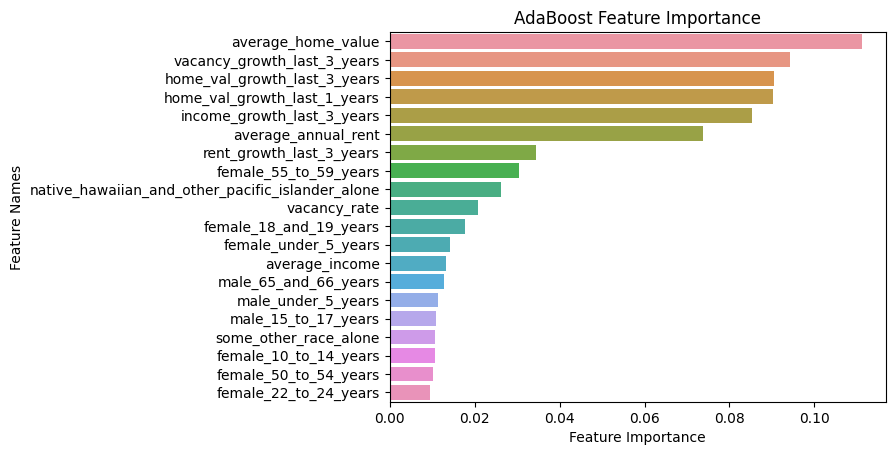

In [41]:
if sum([1 if 'pca__' in x else 0 for x in ada_params]) == 0:
    feature_names = ex_train.columns
    importances = ada.feature_importances_
    data = {'feature_names': feature_names, 'feature_importance': importances}
    ada_df = pd.DataFrame(data)
    ada_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    ada_df = ada_df.head(20)

    sns.barplot(x = ada_df['feature_importance'], y = ada_df['feature_names'], ci = None)

    
    plt.title('AdaBoost Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    

In [42]:
# TUNED XGBOOST

In [43]:
%store -r xgboost_params

In [44]:
xgboost_params

{'scale_pos_weight': 0.25, 'max_depth': 5, 'eta': 0.2}

In [45]:
# XGBOOST IS BEING A CRYBABY ABOUT TYPES IDK WHY, BUT WHATEVER I'LL EXPLICITLY FIX LOL
ex_train['average_annual_rent'] = ex_train['average_annual_rent'].astype(float)
ex_train['average_home_value'] = ex_train['average_home_value'].astype(float)
ex_train['average_income'] = ex_train['average_income'].astype(float)

ex_vali['average_annual_rent'] = ex_vali['average_annual_rent'].astype(float)
ex_vali['average_home_value'] = ex_vali['average_home_value'].astype(float)
ex_vali['average_income'] = ex_vali['average_income'].astype(float)



if sum([1 if 'pca__' in x else 0 for x in xgboost_params]) > 0:
    steps = [('pca', PCA(n_components = xgboost_params['pca__n_components'])), 
             ('xg', XGBRegressor(scale_pos_weight = xgboost_params['xg__scale_pos_weight'],
                                  max_depth = xgboost_params['xg__max_depth'], 
                                  eta = xgboost_params['xg__eta']))]
             
    xg = Pipeline(steps = steps)
    
else:
    xg = XGBRegressor(scale_pos_weight = xgboost_params['scale_pos_weight'],
                  max_depth = xgboost_params['max_depth'], 
                  eta = xgboost_params['eta'])

# TRAIN/VALI
xg_fit = xg.fit(ex_train, why_train)
xg_preds = xg_fit.predict(ex_vali)
print('rmse - ', m.sqrt(mse(why_vali, xg_preds)))
print('mae - ', mae(why_vali, xg_preds))

# PERFORMANCE BEEN BAD SO WANNA SHPEEP TRAINING SCORES TOO - ARE WE OVER OR UNDER FITTING?
xg_train_preds = xg.fit(ex_train, why_train).predict(ex_train)
print('training rmse - ', m.sqrt(mse(why_train, xg_train_preds)))
print('training mae - ', mae(why_train, xg_train_preds))

rmse -  0.18975554663184352
mae -  0.15895004559267684
training rmse -  0.027117778704513203
training mae -  0.02059930110561727


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15587/2985922371.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)


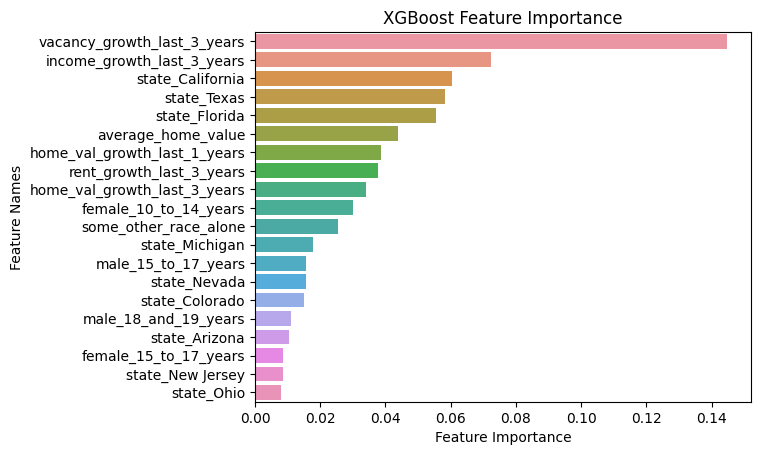

In [46]:
if sum([1 if 'pca__' in x else 0 for x in xgboost_params]) == 0:
    feature_names = ex_train.columns
    importances = xg_fit.feature_importances_
    data = {'feature_names': feature_names, 'feature_importance': importances}
    xg_df = pd.DataFrame(data)
    xg_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    xg_df = xg_df.head(20)

    sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)

    #ADD CHART LABELS
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    

In [47]:
# Apply StandardScaler and PCA transformations separately
scaler = StandardScaler()
pca = PCA(n_components=xgboost_params['pca__n_components']) if 'pca__n_components' in xgboost_params else None

# Fit and transform the training data
# REMOVING FOR NOW BECAUSE PCA NOT USED
X_train_scaled = scaler.fit_transform(ex_train_upsampled)
X_vali_scaled = scaler.transform(ex_vali)
X_test_scaled = scaler.transform(ex_test)

if pca:
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_vali_pca = pca.transform(X_vali_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'scale_pos_weight': xgboost_params['xg__scale_pos_weight'],
    'max_depth': xgboost_params['xg__max_depth'],
    'eta': xgboost_params['xg__eta']
    }
else:
    X_train_pca = X_train_scaled
    X_vali_pca = X_vali_scaled
    X_test_pca = X_test_scaled
    
    params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'scale_pos_weight': xgboost_params['scale_pos_weight'],
    'max_depth': xgboost_params['max_depth'],
    'eta': xgboost_params['eta']
    }

# Use PCA-transformed data for XGBoost training
dtrain = xgb.DMatrix(X_train_pca, label=why_train_upsampled)
dval = xgb.DMatrix(X_vali_pca, label=why_vali)
dtest = xgb.DMatrix(X_test_pca, label=why_test)

evals = [(dtrain, 'train'), (dval, 'eval')]
xgboost_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=evals
)

xg_stopped_preds = xgboost_model.predict(dval)
xg_stopped_error = mse(why_vali, xg_stopped_preds)

print(xg_stopped_error)


[0]	train-rmse:0.28939	eval-rmse:0.14947
[1]	train-rmse:0.23725	eval-rmse:0.11791
[2]	train-rmse:0.19608	eval-rmse:0.09904
[3]	train-rmse:0.16372	eval-rmse:0.09856
[4]	train-rmse:0.13811	eval-rmse:0.10575
[5]	train-rmse:0.11847	eval-rmse:0.11564
[6]	train-rmse:0.10299	eval-rmse:0.12859
[7]	train-rmse:0.09137	eval-rmse:0.13800
[8]	train-rmse:0.08216	eval-rmse:0.14402
[9]	train-rmse:0.07549	eval-rmse:0.14993
[10]	train-rmse:0.06953	eval-rmse:0.15834
[11]	train-rmse:0.06497	eval-rmse:0.15794
[12]	train-rmse:0.06147	eval-rmse:0.15953
[13]	train-rmse:0.05890	eval-rmse:0.16225
0.026323921402865682


In [48]:
# DOUBLE CHECKING TEST
print(mse(why_test, xgboost_model.predict(dtest)))

0.0737078848007355


/var/folders/ks/kw717xj15yb5_wtd_n8xp6tr0000gn/T/ipykernel_15587/2668510930.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)


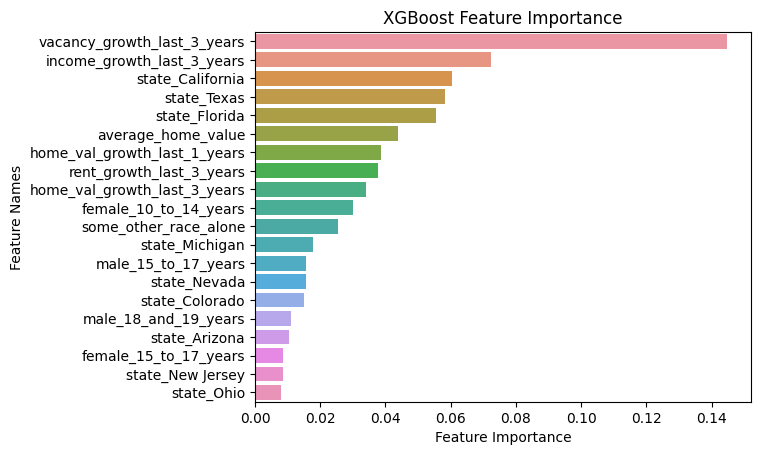

In [49]:
if sum([1 if 'pca__' in x else 0 for x in xgboost_params]) == 0:
    feature_names = ex_train.columns
    importances = xg_fit.feature_importances_
    data = {'feature_names': feature_names, 'feature_importance': importances}
    xg_df = pd.DataFrame(data)
    xg_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    xg_df = xg_df.head(20)

    sns.barplot(x = xg_df['feature_importance'], y = xg_df['feature_names'], ci = None)

   
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    

In [50]:
# EARLY STOPPING BOOSTED MODELS BOTH SOLID; V CLOSE PERFORMANCE SO LET'S OPT FOR AN ENSEMBLE PREDICTION

canon_preds = [(x + y)/2 for x, y in zip(ada_stopped_preds, xg_stopped_preds)]

vali['predicted_roi'] = canon_preds

In [51]:
# SORT VALIDATION BY PREDICTED ROI AND DROP COLUMNS UNNECESSARY FOR LATER CHECKS
pred_check = vali.sort_values(by = 'predicted_roi', ascending = False)
pred_check = pred_check.drop(columns = [x for x in df.columns if x != 'place' and\
                                        x != 'year' and x != 'average_annual_rent' and\
                                        x != 'average_home_value' and x != 'total_population' and\
                                        'roi' not in x])


In [52]:
# PULL ERRORS
df_ec = vali.copy()
df_ec['error'] = round(df_ec['predicted_roi'] - df_ec['roi'], 3)

Text(0, 0.5, 'Number of Observations')

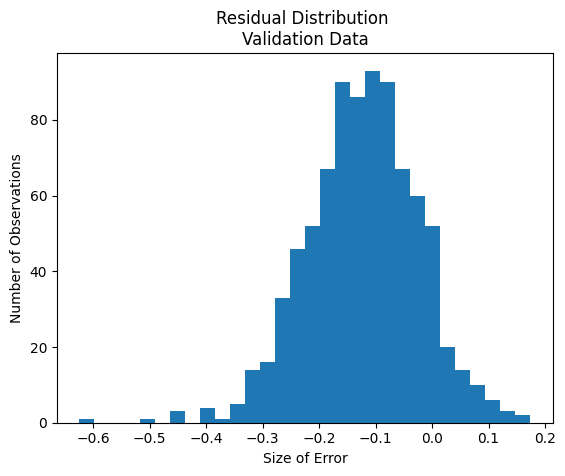

In [53]:
# AND VISUALIZE DISTRIBUTION
plt.hist(df_ec['error'], bins = 30)
plt.title("Residual Distribution \nValidation Data")
plt.xlabel("Size of Error")
plt.ylabel("Number of Observations")


SO, WE HAVE TWO MODELS THAT DO WELL ON ERROR, BUT IT IS WORTH NOTING THAT ERROR IS NORMAL BUT NOT ABOUT ZERO; ROOM FOR IMPROVEMENT IN THE FUTURE, BUT WILLING TO MOVE FORWARD FOR NOW.

NEXT, WE CHECK WITH A MORE "REAL WORLD" TEST. REALISTICALLY WE WOULD NOT BE BUYING AND SHORTING ON EVERY CITY'S REAL ESTATE MARKET, SO THE BETTER APPLICATION IS TO SEE WHAT WOULD HAVE HAPPENED IF WE HAD USED THE MODEL TO IDENTIFY TOP CANDIDATES IN THE LATEST YEAR OF TESTABLE DATA. I CONSIDER ANY CANDIDATE IDENTIFIED THAT WOULD HAVE PERFORMED BETTER THAN AVERAGE ACCEPTABLE (THRESHOLD IN CELL BELOW). GOING TO USE BUDGET CONSTRAINTS AS WELL.

In [54]:
for year in set(train['year'].values.tolist()):
    print(year)
    print(train[train['year'] == year]['roi'].mean())

2009
0.06404906666666665
2010
0.03423398692810457
2011
0.05816506493506494
2012
0.14796522292993633
2013
0.2301561314791403
2014
0.29460024937655865


In [55]:
for year in set(vali['year'].values.tolist()):
    print(year)

2018


In [56]:
pred_check_budget = pred_check[pred_check['average_home_value'] <= 300000]
pred_check_real = pred_check_budget[~pred_check_budget['place'].str.contains('Texas')]
pred_check_real = pred_check_real[~pred_check_real['place'].str.contains('California')]

In [57]:
print('predicted roi mean - ', pred_check_real['predicted_roi'].mean())
print('roi mean - ', pred_check_real['roi'].mean())
print('train mean - ', train[train['average_home_value'] <= 300000]['roi'].mean())

predicted roi mean -  0.20943132640303525
roi mean -  0.3428203980099503
train mean -  0.16103979591836734


In [58]:
print('roi mean - ', pred_check_budget['roi'].mean())

roi mean -  0.34805348360655736


In [59]:
print('roi mean - ', pred_check['roi'].mean())

roi mean -  0.3233958133971292


In [61]:
# pred_check['diff'] = abs(pred_check['roi'] - pred_check['predicted_roi'])
# pred_check.sort_values('predicted_roi').head(25)
pred_check_real.head(25)

,year,place,average_annual_rent,average_home_value,total_population,roi,predicted_roi
254058,2018,Rio Rancho city - New Mexico,11818.92,212908.67,94765,0.3058,0.283475
243514,2018,Tamarac city - Florida,15071.64,178162.49,64748,0.5027,0.274348
257332,2018,Youngstown city - Ohio,5773.92,57514.34,64734,0.4146,0.274185
245437,2018,Oak Lawn village - Illinois,12289.68,198694.85,56420,0.3616,0.269413
242841,2018,Boynton Beach city - Florida,16322.04,221097.94,75720,0.4746,0.268197
245583,2018,Rockford city - Illinois,7867.32,115229.17,147881,0.2708,0.268049
242945,2018,Deltona city - Florida,11386.44,148354.18,89186,0.5684,0.265830
254295,2018,Cheektowaga CDP - New York,8648.64,121624.76,74026,0.4202,0.264797
250193,2018,St. Clair Shores city - Michigan,10314.48,142793.61,59781,0.4485,0.264713
243374,2018,Pine Hills CDP - Florida,10138.20,130756.86,75575,0.7808,0.263618


In [62]:
print('predicted - ', pred_check_budget['predicted_roi'].mean())
print('actual - ', pred_check_budget['roi'].mean())

predicted -  0.21053639150184686
actual -  0.34805348360655736


In [64]:
pred_check_real.sort_values(by = 'roi', ascending = False).head(25)

,year,place,average_annual_rent,average_home_value,total_population,roi,predicted_roi
244395,2018,Caldwell city - Idaho,8265.60,142924.74,53205,0.8646,0.240536
243374,2018,Pine Hills CDP - Florida,10138.20,130756.86,75575,0.7808,0.263618
244502,2018,Nampa city - Idaho,8836.44,163784.54,91663,0.6862,0.229180
249869,2018,Flint city - Michigan,5908.32,47133.92,97161,0.6543,0.253192
243184,2018,Lauderhill city - Florida,13437.12,162409.51,71328,0.6239,0.222092
243246,2018,Miami Gardens city - Florida,12626.88,189457.86,112913,0.6142,0.220047
244490,2018,Meridian city - Idaho,11963.64,258787.66,97008,0.5873,0.132363
255127,2018,Utica city - New York,7521.00,117217.11,60675,0.5846,0.181952
243508,2018,Sunrise city - Florida,16504.92,188047.93,93199,0.5770,0.239808
249821,2018,Detroit city - Michigan,7401.36,75133.92,677155,0.5691,0.228480


In [65]:
[place for place in pred_check.head(25)['place'].values.tolist() if \
 place in pred_check.sort_values(by = 'roi', ascending = False).head(25)['place'].values.tolist()]

[]

In [66]:
df_latest = df_latest.dropna()
df_latest = df_latest.drop(columns = [x for x in df_latest.columns if 'state_' in x])

In [67]:
df_latest['pred'] = round(((df_latest['average_home_value'] * (1 + df_latest['home_val_growth_last_3_years']) - df_latest['average_home_value']) + \
                     (
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_1_years']) +\
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_2_years']) +\
                        df_latest['average_annual_rent'] * (1 + df_latest['rent_growth_last_3_years'])
                     ))/df_latest['average_home_value'], 4)

In [68]:
# MAKE PLACE EASIER FOR API I.E. NO SPACES; WANNA KEEP IN ORIGINAL DF IN CASE I WANT FURTHER ANALYSIS
df_save = df_latest.copy()
df_save['place'] = df_save['place'].apply(lambda x: re.sub(' ', '.', 
                                                           re.sub('St.', 'Saint', 
                                                                  re.sub(' - ', '.', x))))

In [69]:
df_save.to_csv("latest_yrs_w_preds_city.csv", index = False)